<a href="https://colab.research.google.com/github/tomonari-masada/course-nlp2020/blob/master/00_bag_of_words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 軽い前置き
* この授業では、Pythonのコーディングの基礎は習得済みであることを前提します。
* また、NumPyやscikit-learnの基本的な使い方は習得済みであることを前提します。

# 00 bag-of-wordsモデル
* **bag-of-wordsモデル**とは、文書をベクトルとしてモデル化する手法のひとつ。
 * 他にもそのような手法はある。
* bag-of-wordsモデルにおいては、文書における単語トークンの**出現順序が無視される**。
 * 単語トークンとは、単語の一回一回の出現のこと。
* つまり、文書を、バッグに入ったアイテムの集まりのように扱うモデリング（下図参照）。
 * 数学的に言えば、文書を単語の**multiset**として扱うのがbag-of-wordsモデル。

* 参考資料
 * https://github.com/aws-samples/aws-machine-learning-university-accelerated-nlp/blob/master/notebooks/MLA-NLP-Lecture1-BOW.ipynb



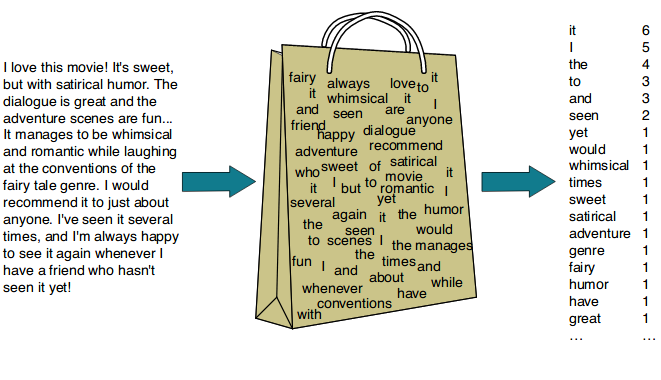

https://dudeperf3ct.github.io/lstm/gru/nlp/2019/01/28/Force-of-LSTM-and-GRU/

* 現在では、言語データをモデル化するとき、必ずと言っていいほど、単語（あるいはsubword）のベクトル表現を用いる。
* この単語ベクトル表現は、埋め込みembeddingとも呼ばれるし、分散表現とも呼ばれる。
* 単語埋め込みが急速に普及したのは、深層学習の普及とほぼ同時期。
* それまではbag-of-wordsが広く使われていた。
* 論文では今でも、文書分類のbaselineとして、TF-IDFやBM25など、bag-of-wordsモデルが引き合いに出されることがある。
 * 例えば、文書分類の新手法を考え出してもbag-of-wordsに勝てなければ意味がない、といった使い方をされる。
* そのため、授業の最初のトピックとして、bag-of-wordモデルについて簡単に説明しておく。
 * BM25については右リンクを参照。 https://nlp.stanford.edu/IR-book/html/htmledition/okapi-bm25-a-non-binary-model-1.html



---


興味がある方は、スタンフォード大の自然言語処理の授業が、この10年間でいかに大きく内容を変えているか、調べてみましょう。

https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/index.html

## 00-01 binary vector
* 最も単純には、文書は、語彙に含まれる各単語が出現するかしないかの2値ベクトルでモデル化できる。

### scikit-learnのCountVectorizer
* 各documentは、半角スペースでつながれた単語の列として準備しておく。
 * これをどうやって作るかは、後で説明する。
* binaryをTrueにセットすると、0/1の2値ベクトルが得られる。
* インスタンスを作り、fit_transformする、という使い方は、scikit-learnにおけるデータの前処理のときと同様。

In [1]:
from sklearn.feature_extraction.text import CountVectorizer

### 文書の集合＝コーパスを用意する。

In [2]:
corpus = ["This document is the first document.",
          "This document is the second document.",
          "And this is the third one.",
          "Where is the fourth one?"]

### CountVectorizerをbinary=Trueで使う

In [3]:
binary_vectorizer = CountVectorizer(binary=True) # 2値ベクトルとして表現
X = binary_vectorizer.fit_transform(corpus)

### 文書の2値ベクトル表現の確認
* 疎なベクトルとして得られることに注意。

In [4]:
print(X)

  (0, 9)	1
  (0, 1)	1
  (0, 4)	1
  (0, 7)	1
  (0, 2)	1
  (1, 9)	1
  (1, 1)	1
  (1, 4)	1
  (1, 7)	1
  (1, 6)	1
  (2, 9)	1
  (2, 4)	1
  (2, 7)	1
  (2, 0)	1
  (2, 8)	1
  (2, 5)	1
  (3, 4)	1
  (3, 7)	1
  (3, 5)	1
  (3, 10)	1
  (3, 3)	1


### 疎な表現を通常のndarrayに戻す

In [5]:
X.toarray()

array([[0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0],
       [0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0],
       [1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0],
       [0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1]])

### 語彙を得る
* 先頭の大文字は自動的に小文字に変換されていることが分かる。
* ピリオドや疑問符は削除されている。

In [6]:
binary_vectorizer.vocabulary_

{'and': 0,
 'document': 1,
 'first': 2,
 'fourth': 3,
 'is': 4,
 'one': 5,
 'second': 6,
 'the': 7,
 'third': 8,
 'this': 9,
 'where': 10}

In [7]:
print(binary_vectorizer.get_feature_names())

['and', 'document', 'first', 'fourth', 'is', 'one', 'second', 'the', 'third', 'this', 'where']


### 新しい文書をベクトルに変換する

In [8]:
new_doc = ["This is the new document."]

new_vectors = binary_vectorizer.transform(new_doc)

### 新出の単語は無視される点に注意

In [9]:
new_vectors.toarray()

array([[0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]])

## 00-02 word counts
* 文書における各単語の出現回数を使って、文書のベクトル表現を得ることもできる。

### CountVectorizerをデフォルト設定で使う

In [10]:
count_vectorizer = CountVectorizer()
X = count_vectorizer.fit_transform(corpus)

In [11]:
X.toarray()

array([[0, 2, 1, 0, 1, 0, 0, 1, 0, 1, 0],
       [0, 2, 0, 0, 1, 0, 1, 1, 0, 1, 0],
       [1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0],
       [0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1]])

In [12]:
new_vectors = count_vectorizer.transform(new_doc)
new_vectors.toarray()

array([[0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]])

## 00-03 TF-IDF
* TF-IDFは、TFとIDFの積である。
* 文書に含まれる単語トークンの数（つまり、単語の出現回数の総和）を、その文書の長さと呼ぶ。
* TFとは、各々の単語が文書のなかで出現する回数を、その文書の長さで割ったものである。
 * 文書のなかで頻出する単語ほどTFは大きくなる。
* IDFとは、DFの逆数である。
* DFとは、ある単語が含まれる文書の数を、総文書数で割ったものである。
 * 文書集合のなかで稀少な単語ほどIDFは大きくなる。

* TF-IDFはTFとIDFの積であるが、積を求める前に、TFのルートを取ったり対数をとったり、あるいは、IDFのルートをとったり対数をとったりする。
 * 対数をとるときは、ゼロの対数をとることにならないような工夫をする。


---



### TF-IDFの式の例

$x_{d,w} = \frac{n_{d,w}}{n_d} \cdot ( 1 + \ln\frac{m}{m_w})$

where 

 * $n_{d,w}$ is the frequency of the word $w$ in the document $d$, 
 * $n_d$ is defined as $n_d \equiv \sum_w n_{d,w}$,
 * $m_w$ is the number of documents containing the word $w$, and
 * $m$ is the total number of documents.


---

* どの式の形がいいかは、downstream taskの性能をcross validationで評価して選ぶ。

### scikit-learnのTfidfVectorizer

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()

In [14]:
X = tfidf_vectorizer.fit_transform(corpus).toarray()

X

array([[0.        , 0.74846041, 0.47466356, 0.        , 0.24769914,
        0.        , 0.        , 0.24769914, 0.        , 0.3029716 ,
        0.        ],
       [0.        , 0.74846041, 0.        , 0.        , 0.24769914,
        0.        , 0.47466356, 0.24769914, 0.        , 0.3029716 ,
        0.        ],
       [0.52898651, 0.        , 0.        , 0.        , 0.2760471 ,
        0.41705904, 0.        , 0.2760471 , 0.52898651, 0.33764523,
        0.        ],
       [0.        , 0.        , 0.        , 0.56199026, 0.29326983,
        0.44307958, 0.        , 0.29326983, 0.        , 0.        ,
        0.56199026]])

In [15]:
import numpy as np
np.linalg.norm(X, axis=1)

array([1., 1., 1., 1.])

In [16]:
new_vectors = tfidf_vectorizer.transform(new_doc).toarray()
new_vectors

array([[0.        , 0.6284927 , 0.        , 0.        , 0.41599288,
        0.        , 0.        , 0.41599288, 0.        , 0.50881901,
        0.        ]])

### 各単語のIDF
* IDFはそれぞれの単語について一意に決まる値。
* 文書ごとに求まる値ではない。

In [17]:
tfidf_vectorizer.idf_

array([1.91629073, 1.51082562, 1.91629073, 1.91629073, 1.        ,
       1.51082562, 1.91629073, 1.        , 1.91629073, 1.22314355,
       1.91629073])

### bag-of-wordsベクトルの使い方
* 文書どうしの類似度の計算

In [18]:
from scipy.spatial.distance import cosine

for i in range(4):
  print(cosine(X[i], new_vectors[0]))

0.16935823372188463
0.16935823372188452
0.598532429668177
0.756003678372484
